
### Project : Forecast Order Demand and Visualization


***STEPS/Work Flow***

* Import data and libaries: Self Explanatory
* Explore the Dataset: Check Nulls, Skew, Data Types, Univariate and Bivariate Analysis.
* Explore the Dataset as a Time Series: Min/Max Dates, Check Seasonality, Trends etc.
* ARIMA Model - Some Theory, Choose Best Params (Grid Seach), Build/Fit, Validation, Forecast Accuracy. 
* The END.

I will try and implement some other models including deep network and Facebook's Prophet in later commits.

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
#Import the data and parse dates.
df  = pd.read_csv('Historical Product Demand.csv', parse_dates=['Date'])

In [10]:
#Top 5 rows
df.head(5)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [11]:
#Check the cardinality.
df.shape

(1048575, 5)

In [12]:
#Check the data types.
df.dtypes

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                object
dtype: object

In [14]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

1  /  5
11239  /  1048575


In [15]:
#Lets check where these nulls are.
print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)
#There are missing values in Dates.

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
Null to Dataset Ratio in Dates:  1.0718355863910547


In [ ]:
#Drop na's.

#Since the number of missing values are about 1%, I am taking an 'executive decision' of removing them. ;) 
df.dropna(axis=0, inplace=True) #remove all rows with na's.
df.reset_index(drop=True)
df.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
75193,Product_0642,Whse_C,Category_019,2011-10-31,3
121820,Product_0202,Whse_A,Category_007,2011-11-04,(100)
121819,Product_0202,Whse_A,Category_007,2011-11-04,(400)
131028,Product_2143,Whse_S,Category_009,2011-11-18,(25)
131031,Product_0131,Whse_S,Category_021,2011-11-18,(12)
131032,Product_0288,Whse_S,Category_021,2011-11-18,(50)
44450,Product_0980,Whse_A,Category_028,2011-11-18,4000
131027,Product_2138,Whse_S,Category_009,2011-11-18,(49)
131026,Product_2137,Whse_S,Category_009,2011-11-18,(25)
44795,Product_0965,Whse_A,Category_006,2011-11-18,1


In [16]:
#Target Feature - Order_Demand
#Removing () from the target feature.
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

#Next step is to change the data type.
df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [17]:
#Get the lowest and highest dates in the dataset.
df['Date'].min() , df['Date'].max()
#There is data for 6 years. great.

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [18]:
#Lets start with 2012 and cap it 2016 december. Since the dates before 2012 have a lot of missing values - inspected and checked using basic time series plot.
df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

Lets inspect the data to see why a linear model without any transformation would fail to capture the essence of the data.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


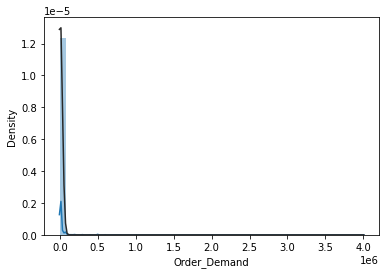

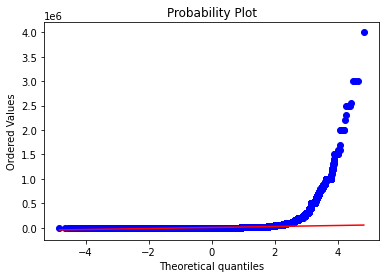

In [21]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 6,4

sb.distplot(df['Order_Demand'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['Order_Demand'], plot=plt)
plt.show()

In [23]:
#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
df['Order_Demand'].skew()

31.506080242695006

In [ ]:
#Just in case if there needs to be some transformation, it can be done by either taking log values or using box cox.

## In case you need to normalize data, use Box Cox. Pick the one that looks MOST like a normal distribution.
# for i in [1,2,3,4,5,6,7,8]:
#     plt.hist(df['Order_Demand']**(1/i), bins= 40, normed=False)
#     plt.title("Box Cox transformation: 1/{}". format(str(i)))
#     plt.show()

Univariate Analysis - Warehouse, Product Category.


In [24]:
#Warehouse shipping by orders.
df['Warehouse'].value_counts().sort_values(ascending = False)

Whse_J    764215
Whse_A    142197
Whse_S     88024
Whse_C     42207
Name: Warehouse, dtype: int64

In [25]:
#The amount of orders shipped by each warehouse.
df.groupby('Warehouse').sum().sort_values('Order_Demand', ascending = False)
#Warehouse J is clearly shipping most orders. Although S is shipping more quantity within fewer requested orders.

,Order_Demand
Warehouse,
Whse_J,3362742530
Whse_S,1033121811
Whse_C,582004179
Whse_A,147646550


33


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text major ticklabel objects>)

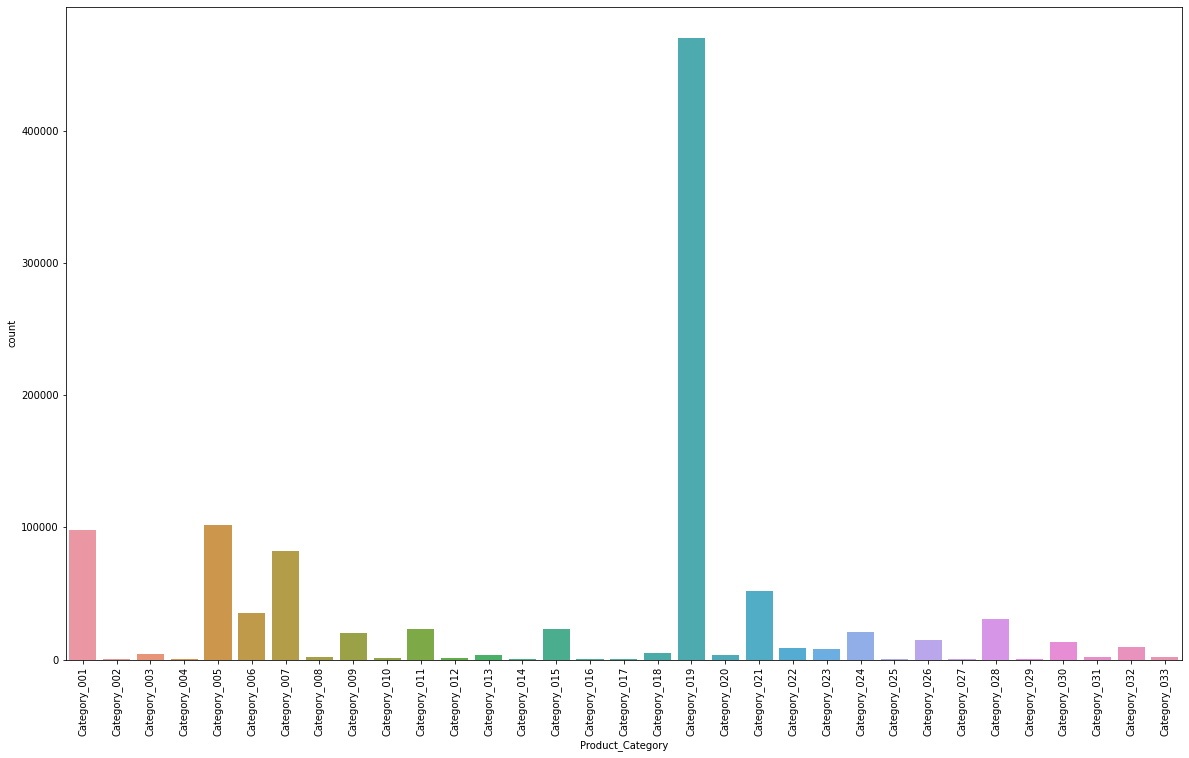

In [30]:
#Product Category.

print (len(df['Product_Category'].value_counts()))

rcParams['figure.figsize'] = 20,12
sb.countplot(df['Product_Category'].sort_values(ascending = True))
plt.xticks(rotation=90)
#There's a lot of orders on category19.

Bivariate Analysis - Warehouse, Product Category with target variable.


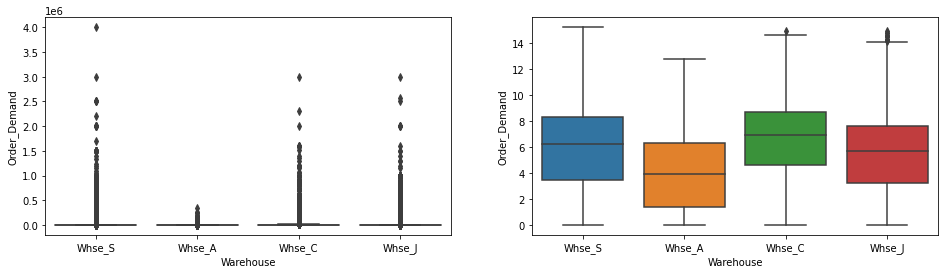

In [ ]:
#Lets check the orders by warehouse.

#Checking with Boxplots
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)
#Regular Data
fig3 = sb.boxplot( df['Warehouse'],df['Order_Demand'], ax = axes[0])
#Data with Log Transformation
fig4 = sb.boxplot( df['Warehouse'], np.log1p(df['Order_Demand']),ax = axes[1])

del fig3, fig4

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text major ticklabel objects>)

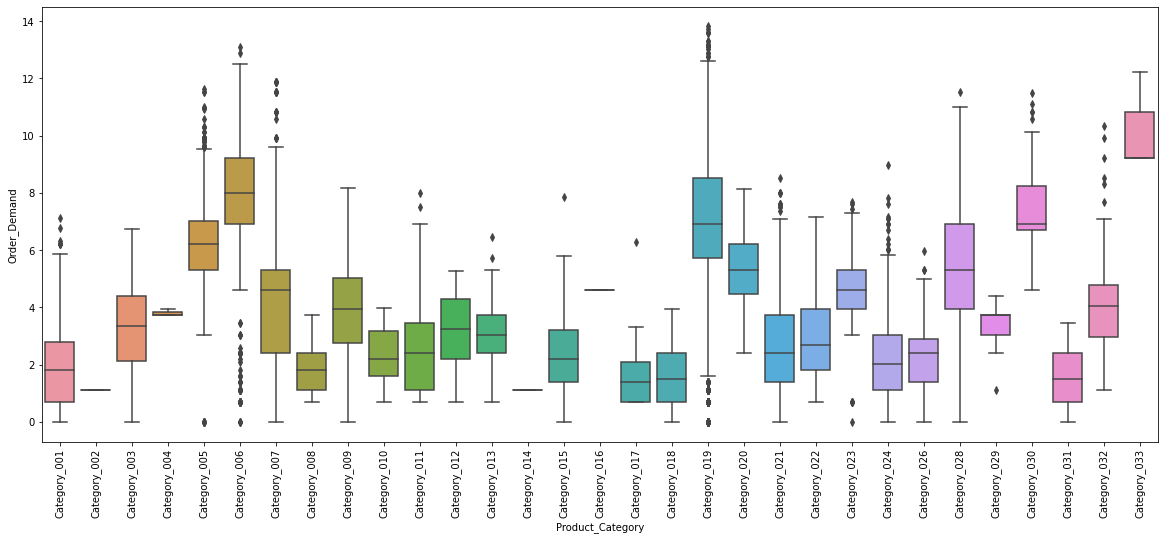

In [32]:
#Lets check the Orders by Product Category.
rcParams['figure.figsize'] = 20,8
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sb.boxplot( df_temp['Product_Category'].sort_values(),np.log1p(df_temp['Order_Demand']))
del df_temp, fig5
plt.xticks(rotation=90)

**Exploring the Data as TIME SERIES**

In [34]:
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
#This gives us the total orders placed on each day.

In [35]:
#Index the date
df = df.set_index('Date')
df.index #Lets check the index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

In [36]:
#Averages daily sales value for the month, and we are using the start of each month as the timestamp.
y = df['Order_Demand'].resample('MS').mean()

In [37]:
#In case there are Null values, they can be imputed using bfill.
#y = y.fillna(y.bfill())

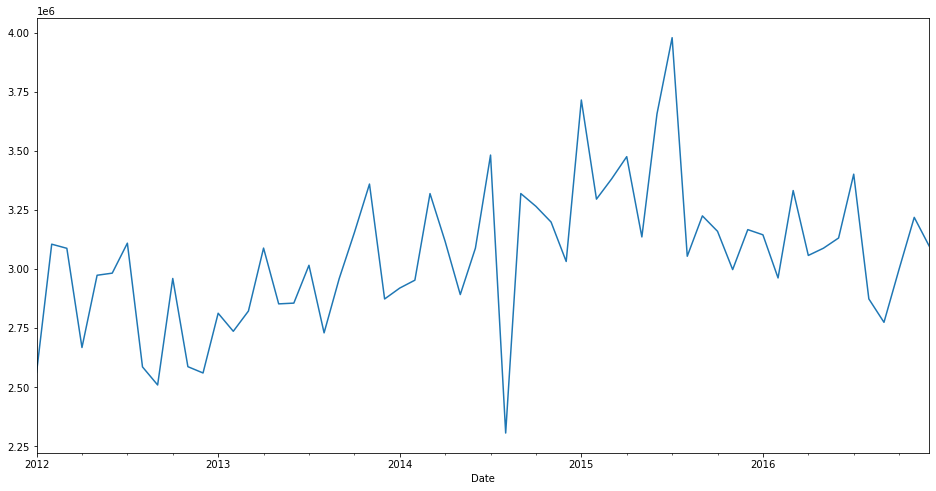

In [38]:
#Visualizing time series.

y.plot(figsize=(16,8))
plt.show()

#Takeaway: The sales are always low for the beginning of the year and the highest peak in demand every year is in the
#last quarter. The observed trend shows that orders were higher during 2014-2016 then reducing.

#Lets check it by decomposition.

Decomposition is a great way to check the seasonality, trends and residuals.

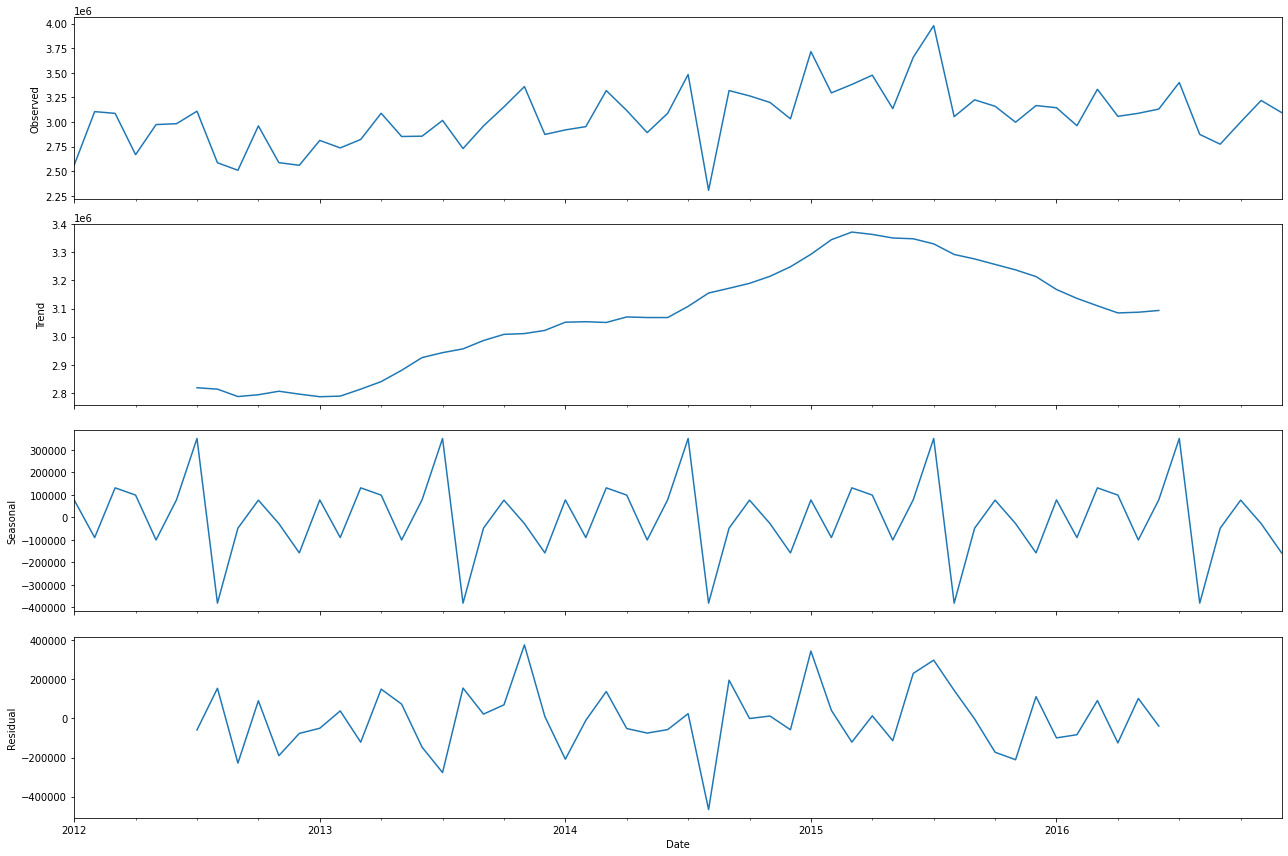

In [39]:
#The best part about time series data and decomposition is that you can break down the data into the following:
#Time Series Decomposition. 
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 12
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

**Theory on ARIMA**

An ARIMA model is characterized by 3 terms: p, d, q where these three parameters account for seasonality (p), trend (d), and noise in data (q):

* p is the order of the AR term (number of lags of Y to be used as predictors). If it snowed for the last wee, it is likely it will snow tomorrow.
* q is the order of the MA term (moving average).  
* d is the number of differencing required to make the time series stationary. if already stationary d=0.
* 
But when dealing with SEASONALITY, it is best to incorporate it as 's'. 
ARIMA(p,d,q)(P,D,Q)s.
Where 'pdq' are non seasonal params and 's' is the perdiocity of the time series. 4:quarter, 12:yearly etc.

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, 
short for ‘Seasonal ARIMA’.

**Grid Search**

Since ARIMA has hyper params that can be tuned, the objective here is to find the best params using Grid Search.

In [40]:
#GRID SEARCH for Param Tuning.
#Sample params for seasonal arima. (SARIMAX).

#For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function 
#from the statsmodels module and assess its overall quality.

import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [41]:
#Get the best params for the data. Choose the lowest AIC.

# The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a 
# given set of data. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# Large AIC: Model fits very well using a lot of features.
# Small AIC: Model fits similar fit but using lesser features. 
# Hence LOWER THE AIC, the better it is.

#The code tests the given params using sarimax and outputs the AIC scores.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1932.23655778549
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.9275832124363
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1338.8201294951011
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3136.551556406792
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1366.5117513512635
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1340.8450308457734
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.6756022859483
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3088.6748256324345
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1862.0874878045222
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1471.1838032700655
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1305.3289813345482
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3051.227357011015
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1529.10057216508
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.6395590277853
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1020.6347629759122
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3032.511327018732
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1648.7378898187837
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:

Fit the Model

In [42]:
#Fit the model with the best params.
#ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:960.5164122018646


#The above output suggests that ARIMA(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value: 960.516
#Therefore we should consider this to be optimal option.

from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2450      0.368     -0.666      0.505      -0.966       0.476
ma.L1         -0.4385      0.325     -1.348      0.178      -1.076       0.199
ar.S.L12      -0.4568      0.208     -2.192      0.028      -0.865      -0.048
sigma2      1.018e+11   9.55e-13   1.06e+23      0.000    1.02e+11    1.02e+11


Interpreting the table:

coeff: Shows weight/impotance how each feature impacts the time series.
Pvalue: Shows the significance of each feature weight. Can test hypothesis using this.
If p value is <.05 then they are statitically significant.

Refresher on null hyp and pvalues.
By default we take the null hyp as 'there is no relationship bw them'
If p value < .05 (significance level) then you reject the Null Hypthesis
If p value > .05 , then you fail to reject the Null Hypothesis.

So, if the p-value is < .05 then there is a relationship between the response and predictor. Hence, significant.

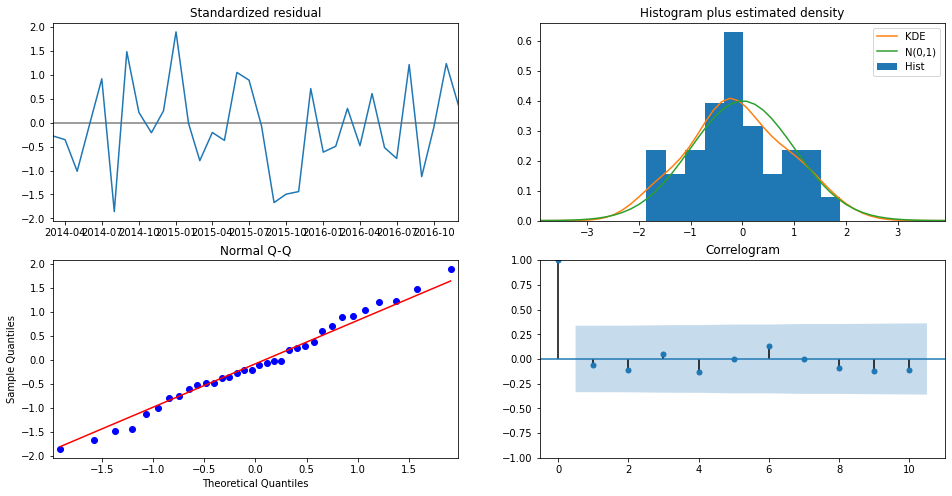

In [43]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.


Model Validation

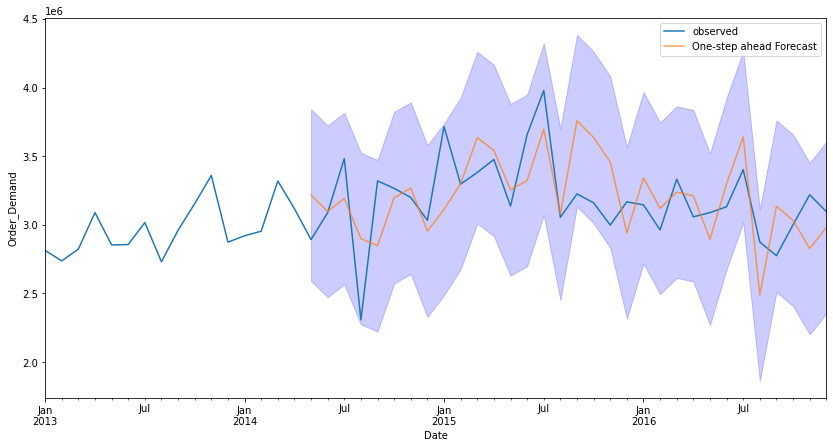

In [44]:
#Lets get the predictions and confidence interval for those predictions.
#Get the predictions. The forecasts start from the 1st of Jan 2017 but the previous line shows how it fits to the data.
pred = results.get_prediction(start=pd.to_datetime('2014-05-01'), dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Takeaway: The forecats seems to be fitting well to the data. The Blue/purple thicker plot shows the confidence level in the forecasts. 

Forecast Accuracy

In [45]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 55459437820.18


In [46]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 235498.28


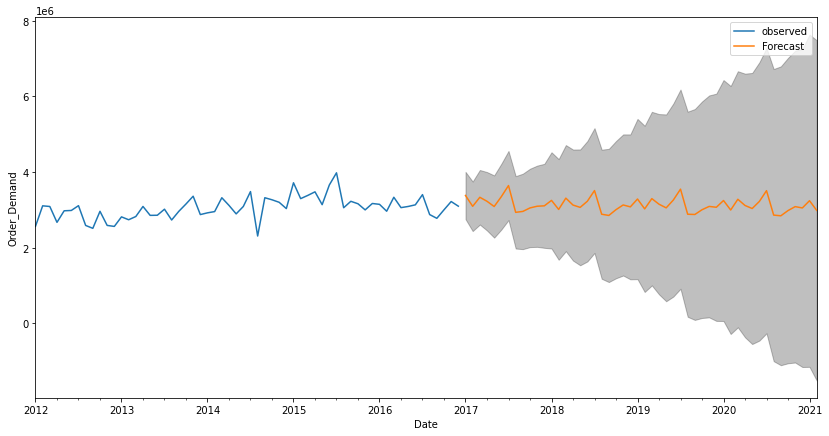

In [47]:
#The time can be changed using steps.
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

#Far out values are naturally more prone to variance. The grey area is the confidence we have in the predictions.

In [48]:
#And that is how you build a somewhat accurate forecast of the demand. Next steps include checking and modeling demand by category type.